In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import datetime as dt
from datetime import date
from sklearn.cluster import KMeans
import regex,re
import openpyxl

# Set the path & Read the file

In [6]:
os.getcwd()

'/Users/samuelchazy/ML_files_X/Applied_Projects/Experiments/Retail_CLV'

In [7]:
# file_path = '/Users/samuelchazy/ML_files_X/Applied_Projects/RFM/'
# os.chdir(file_path)

In [26]:
df = pd.read_excel('data/Online_Retail_1_year.xlsx')

In [27]:
df

InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

               InvoiceDate  UnitPrice  CustomerID         Country  
0      2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1      2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2      2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3      2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4      2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
...                    ...        ...         ...             ...  
541904 2011-12-09 12:50:00       0.85     12680.0          France  
541905 2011-12-09 12:50:00       2.10     12680.0          France  
541906 2011-12-09 12:50:00       4.15     12680.0          France  
541907 2011-12-09 12:50:00       4.15     12680.0          France  
541908 2011-12-09 12:50:00       4.95     12680.0          France  

[541909 rows x 8 columns]

In [28]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

# Rename customer as CustomerID, Invoice as Date, Price as UnitPrice & quantity as Quantity
### Quantity should be > 0, UnitPrice should be > 0 & CustomerID should not be null

In [29]:
df_modified = df.copy()
df_modified = df_modified[df_modified['Country'] == 'United Kingdom']
df_modified = df_modified.drop(['Country','StockCode','Description'],axis=1)
df_modified = df_modified.dropna(subset=['CustomerID'])
df_modified['CustomerID'] = df_modified['CustomerID'].astype(np.int64).astype(object)
df_modified = df_modified[df_modified['Quantity'] >= 0]
df_modified = df_modified[df_modified['UnitPrice'] >= 0]
df_modified['Date'] = df_modified['InvoiceDate'].dt.date
df_modified = df_modified.drop('InvoiceDate',axis=1)
df_modified = df_modified.reset_index(drop=True)
df_modified = df_modified.loc[:,['Date','CustomerID','InvoiceNo','UnitPrice','Quantity']]
df_modified

Date CustomerID InvoiceNo  UnitPrice  Quantity
0       2010-12-01      17850    536365       2.55         6
1       2010-12-01      17850    536365       3.39         6
2       2010-12-01      17850    536365       2.75         8
3       2010-12-01      17850    536365       3.39         6
4       2010-12-01      17850    536365       3.39         6
...            ...        ...       ...        ...       ...
354340  2011-12-09      15804    581585       1.95        12
354341  2011-12-09      13113    581586       2.95         8
354342  2011-12-09      13113    581586       1.25        24
354343  2011-12-09      13113    581586       8.95        24
354344  2011-12-09      13113    581586       7.08        10

[354345 rows x 5 columns]

# Explore the Data

In [30]:
df_modified['Date'].max() - df_modified['Date'].min()

datetime.timedelta(days=373)

In [31]:
df_modified.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354345 entries, 0 to 354344
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Date        354345 non-null  object 
 1   CustomerID  354345 non-null  object 
 2   InvoiceNo   354345 non-null  object 
 3   UnitPrice   354345 non-null  float64
 4   Quantity    354345 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 13.5+ MB


In [32]:
df_modified['Date'] = pd.to_datetime(df_modified['Date'])
df_modified.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354345 entries, 0 to 354344
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   Date        354345 non-null  datetime64[ns]
 1   CustomerID  354345 non-null  object        
 2   InvoiceNo   354345 non-null  object        
 3   UnitPrice   354345 non-null  float64       
 4   Quantity    354345 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 13.5+ MB


In [33]:
df_modified.describe()

UnitPrice       Quantity
count  354345.000000  354345.000000
mean        2.963793      12.048913
std        17.862067     190.428127
min         0.000000       1.000000
25%         1.250000       2.000000
50%         1.950000       4.000000
75%         3.750000      12.000000
max      8142.750000   80995.000000

# Check Outliers

### UnitPrice

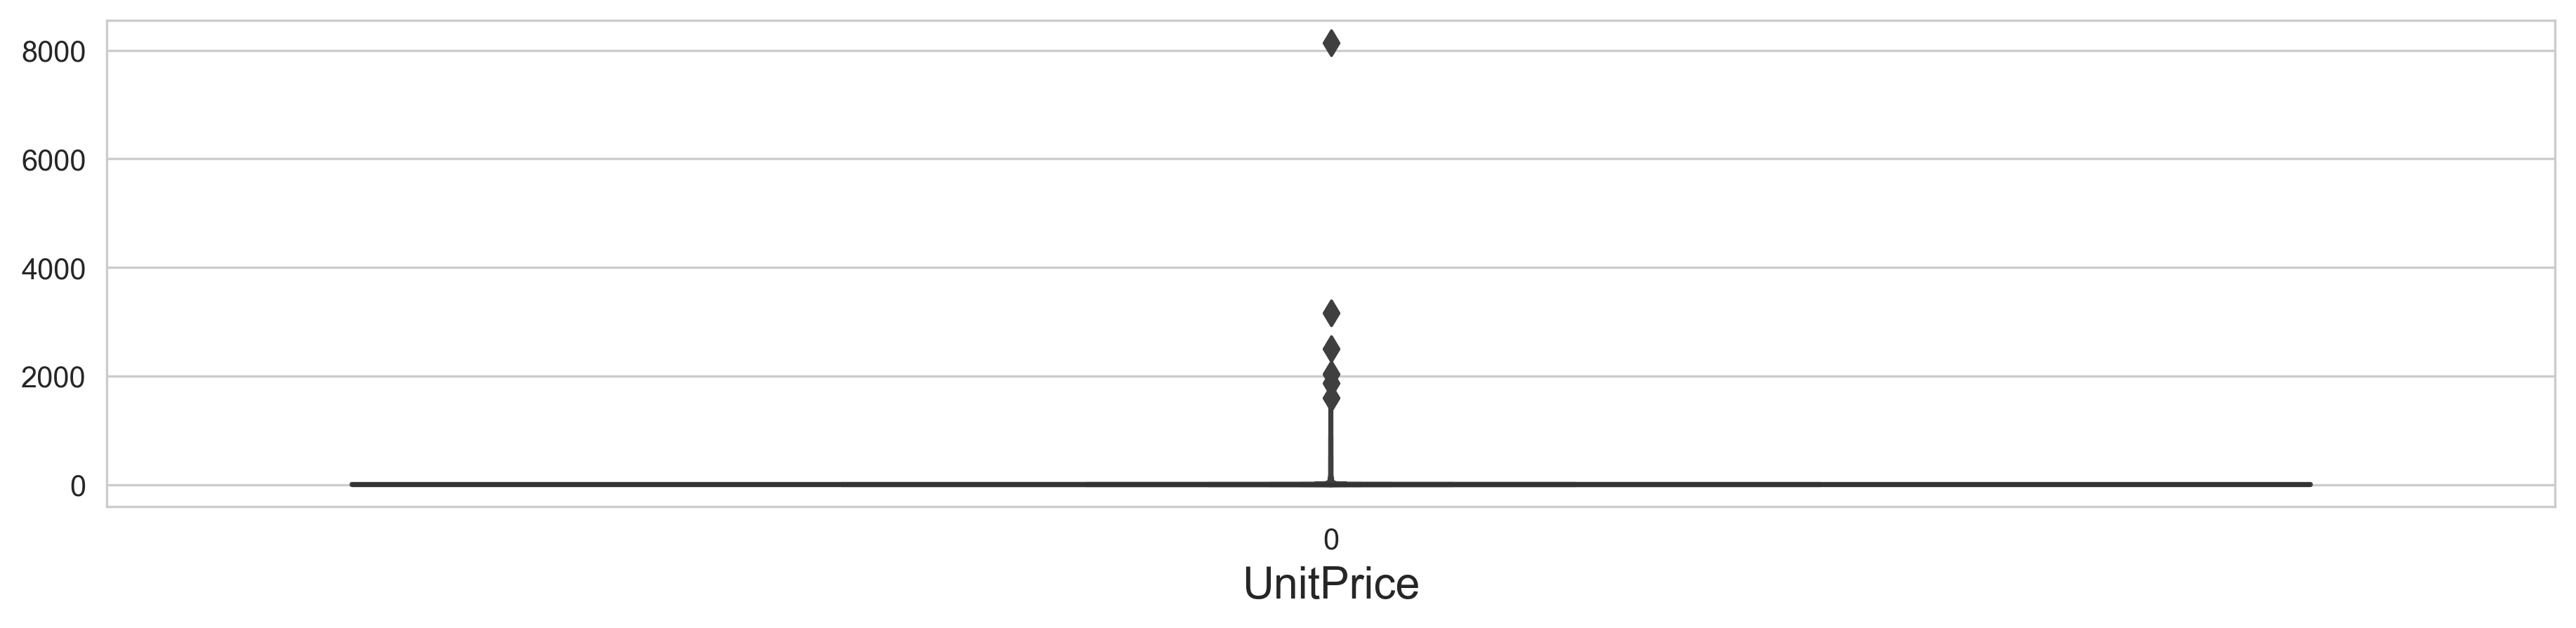

In [34]:
ax,fig = plt.subplots(figsize=(15,3),dpi=300)
ax = sns.boxenplot(data=df_modified['UnitPrice'])
plt.xlabel('UnitPrice',fontsize=15);

In [35]:
lower_bound = df['UnitPrice'].mean() - 3*df['UnitPrice'].std()
higher_bound = df['UnitPrice'].mean() + 3*df['UnitPrice'].std()
df_modified = df_modified[(df_modified['UnitPrice'] > lower_bound) & (df_modified['UnitPrice'] < higher_bound)]

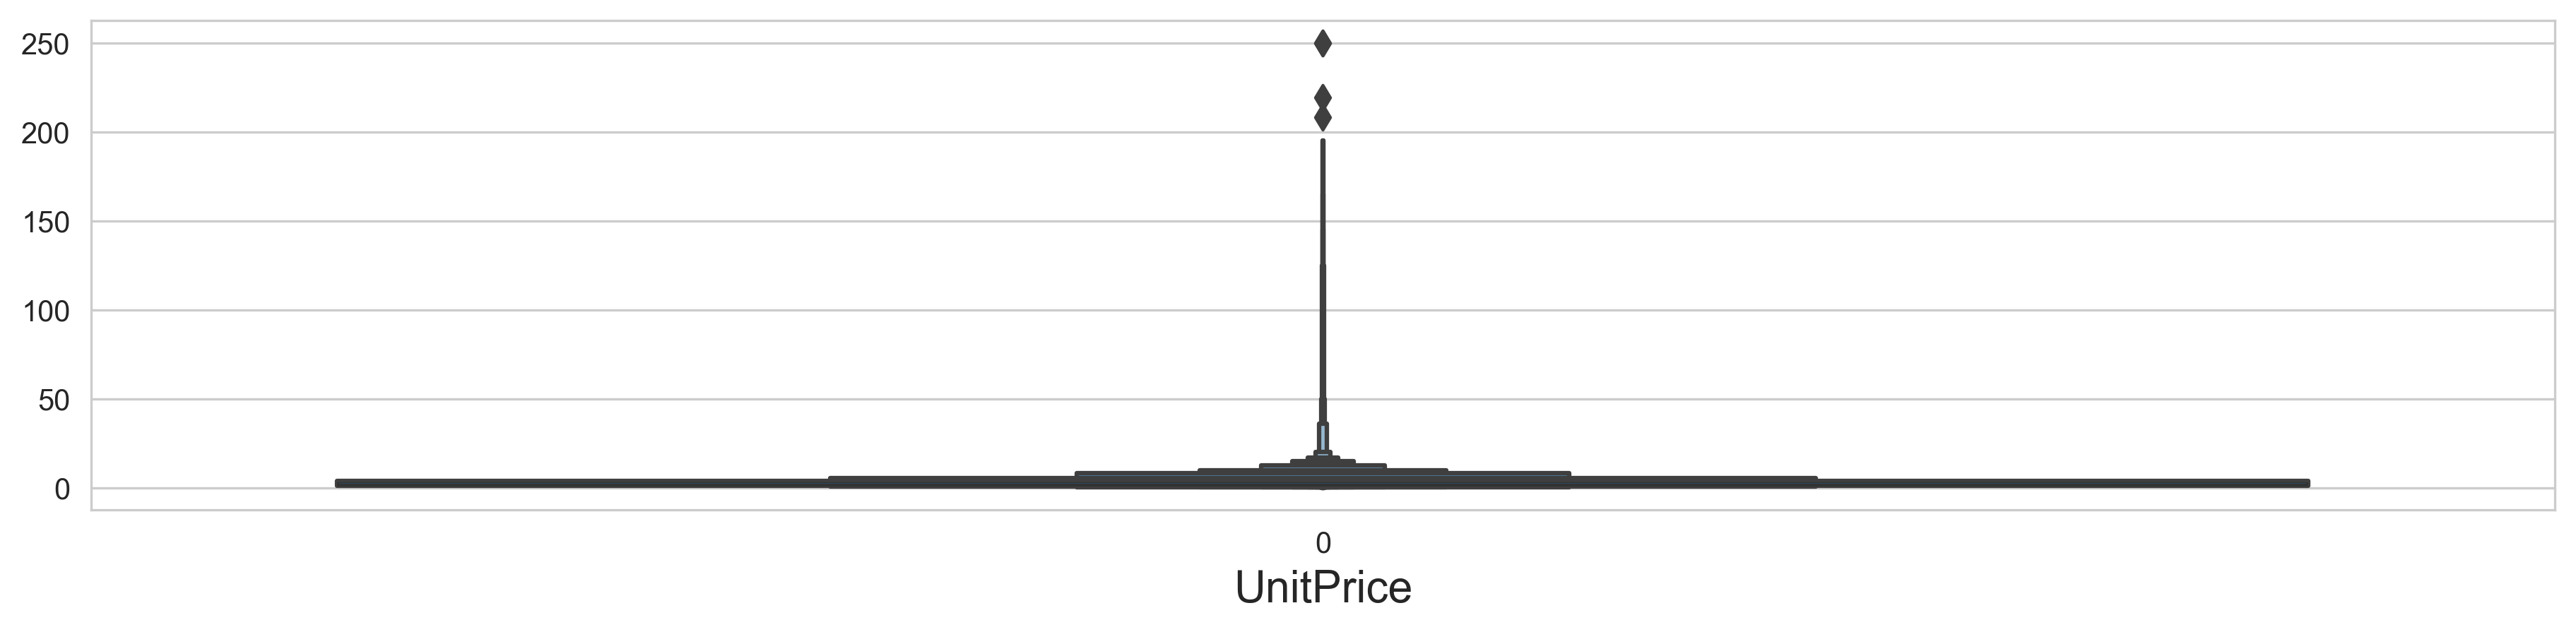

In [36]:
ax,fig = plt.subplots(figsize=(15,3),dpi=300)
ax = sns.boxenplot(data=df_modified['UnitPrice'])
plt.xlabel('UnitPrice',fontsize=15);

### Quantity

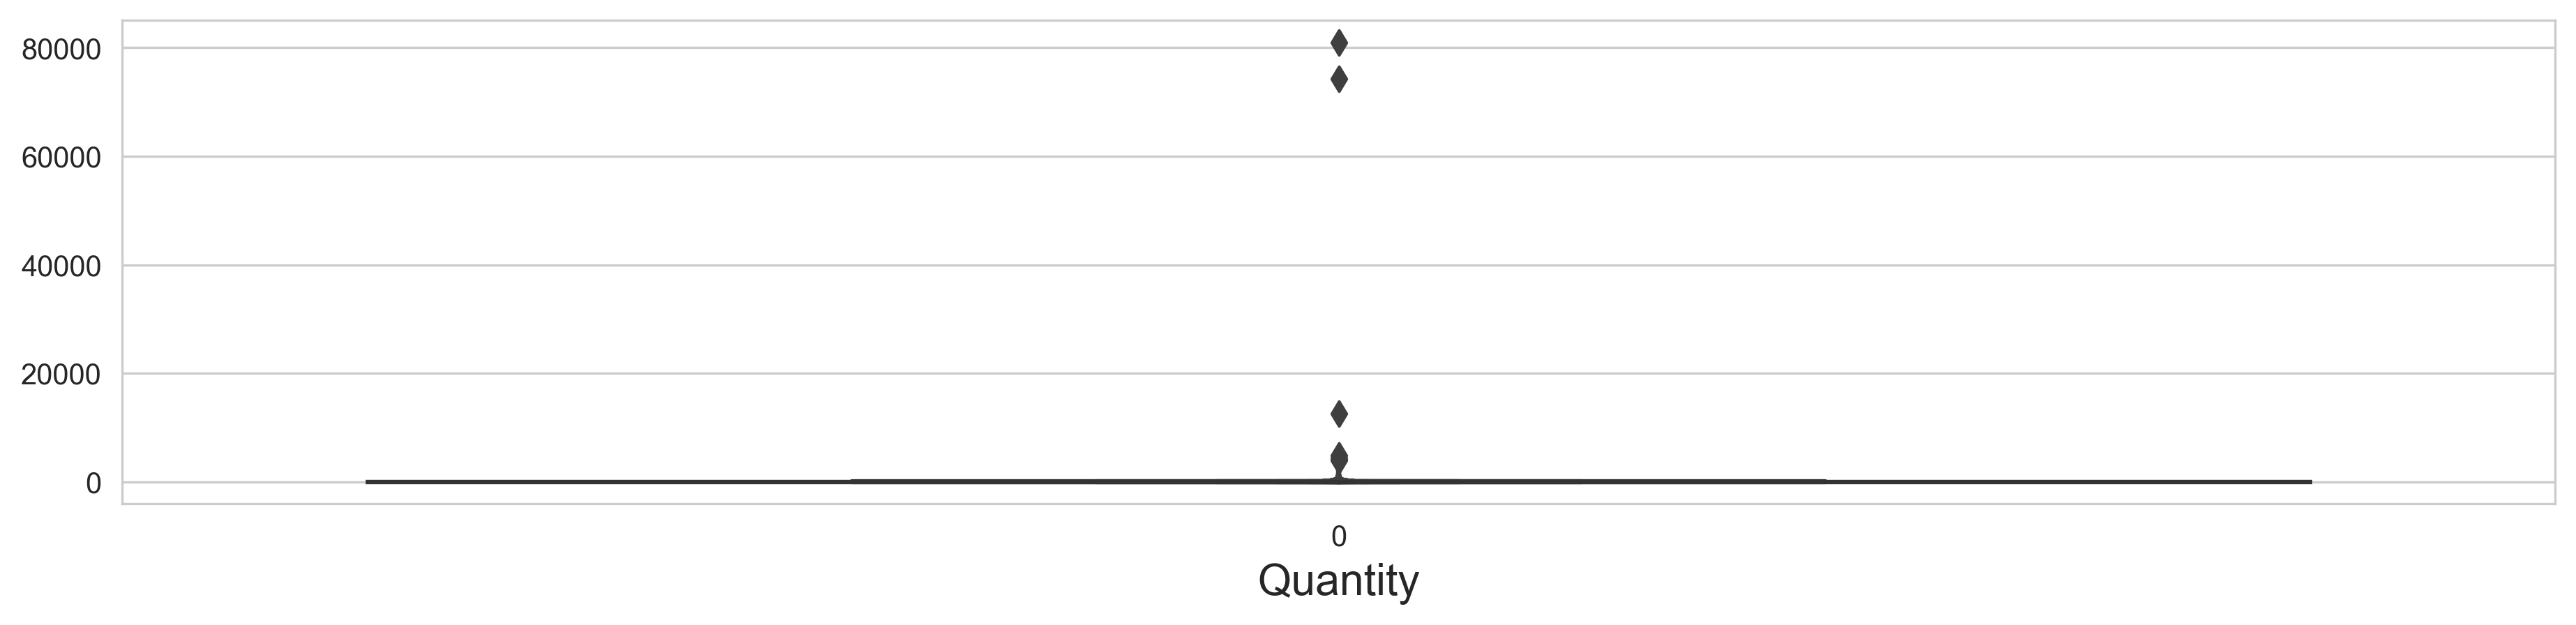

In [37]:
ax,fig = plt.subplots(figsize=(15,3),dpi=300)
ax = sns.boxenplot(data=df_modified['Quantity'])
plt.xlabel('Quantity',fontsize=15);

In [38]:
lower_bound = df['Quantity'].mean() - 3*df['Quantity'].std()
higher_bound = df['Quantity'].mean() + 3*df['Quantity'].std()
df_modified = df_modified[(df_modified['Quantity'] > lower_bound) & (df_modified['Quantity'] < higher_bound)]

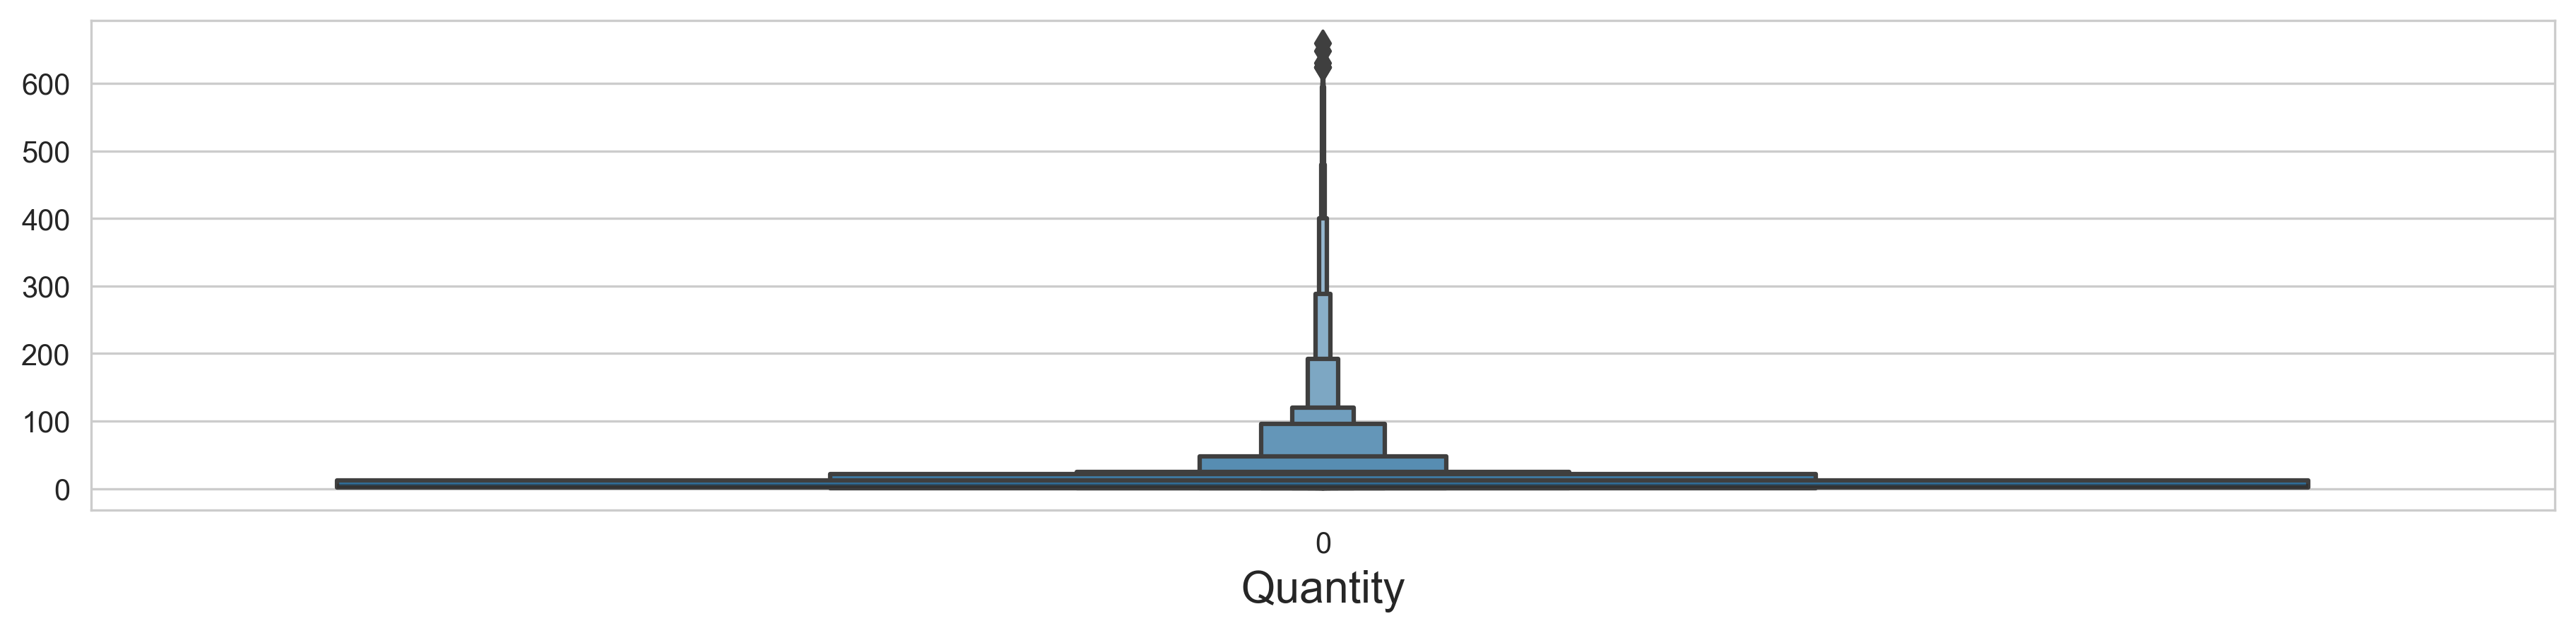

In [39]:
ax,fig = plt.subplots(figsize=(15,3),dpi=300)
ax = sns.boxenplot(data=df_modified['Quantity'])
plt.xlabel('Quantity',fontsize=15);

### Explore the Distribution

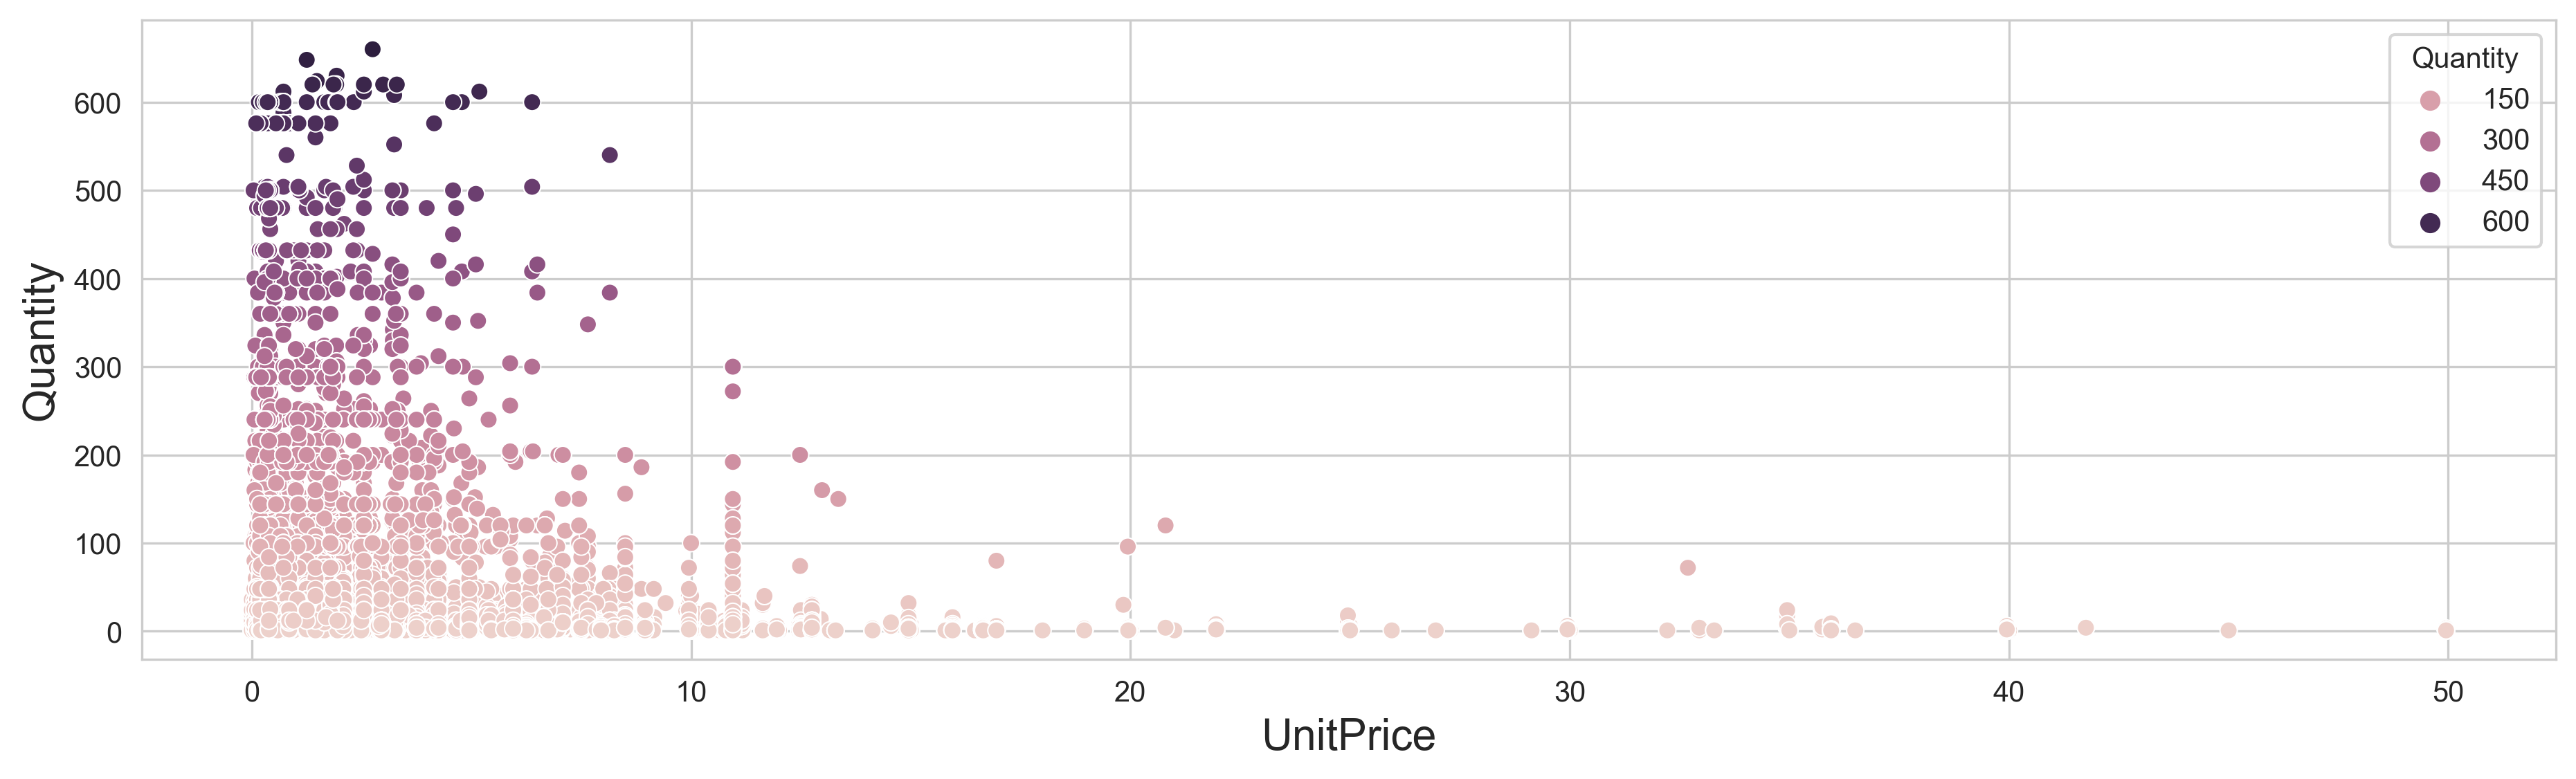

In [40]:
Unit = df_modified[df_modified['UnitPrice'] < 50]['UnitPrice']
Quan = df_modified['Quantity'].dropna()

ax,fig = plt.subplots(figsize=(15,4),dpi=300)
ax = sns.scatterplot(x=Unit,y=Quan,hue=Quan)
plt.xlabel('UnitPrice',fontsize=15)
plt.ylabel('Quantity',fontsize=15)
plt.xticks();

In [42]:
df_modified

Date CustomerID InvoiceNo  UnitPrice  Quantity
0      2010-12-01      17850    536365       2.55         6
1      2010-12-01      17850    536365       3.39         6
2      2010-12-01      17850    536365       2.75         8
3      2010-12-01      17850    536365       3.39         6
4      2010-12-01      17850    536365       3.39         6
...           ...        ...       ...        ...       ...
354340 2011-12-09      15804    581585       1.95        12
354341 2011-12-09      13113    581586       2.95         8
354342 2011-12-09      13113    581586       1.25        24
354343 2011-12-09      13113    581586       8.95        24
354344 2011-12-09      13113    581586       7.08        10

[354092 rows x 5 columns]

In [44]:
df_M = df_modified.copy()
df_M['Monetary'] = round(np.mean(df_M['UnitPrice'] * df_M['Quantity']),2)
df_M = df_M.groupby('CustomerID')['Monetary'].sum().reset_index()
df_M

CustomerID  Monetary
0          12747   1959.06
1          12748  87377.88
2          12749   3784.98
3          12820   1122.18
4          12821    114.12
...          ...       ...
3901       18280    190.20
3902       18281    133.14
3903       18282    228.24
3904       18283  14379.12
3905       18287   1331.40

[3906 rows x 2 columns]

In [45]:
df_M[df_M['CustomerID'] == 13089]

CustomerID  Monetary
190       13089  34578.36

# Save the new data

In [46]:
df_modified.to_excel('retail_clean_data.xlsx')
print('Done!')

Done!


# Explore the Data

In [47]:
df_explore = df.copy()

In [48]:
df_explore['Monetary'] = round(df_explore['UnitPrice'] * df_explore['Quantity'],2)

In [49]:
df_explore

InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

               InvoiceDate  UnitPrice  CustomerID         Country  Monetary  
0      2010-12-01 08:26:00       2.55     17850.0  United Kingdom     15.30  
1      2010-12-01 08:26:00       3.39     17850.0  United Kingdom     20.34  
2      2010-12-01 08:26:00       2.75     17850.0  United Kingdom     22.00  
3      2010-12-01 08:26:00       3.39     17850.0  United Kingdom     20.34  
4      2010-12-01 08:26:00       3.39     17850.0  United Kingdom     20.34  
...                    ...        ...         ...             ...       ...  
541904 2011-12-09 12:50:00       0.85     12680.0          France     10.20  
541905 2011-12-09 12:50:00       2.10     12680.0          France     12.60  
541906 2011-12-09 12:50:00       4.15     12680.0          France     16.60  
541907 2011-12-09 12:50:00       4.15     12680.0          France     16.60  
541908 2011-12-09 12:50:00       4.95     12680.0          France     14.85  

[541909 rows x 9 columns]

In [50]:
customers_per_country = round(df_explore.groupby('Country')['CustomerID'].count().drop(['Unspecified','United Kingdom']).reset_index().sort_values(by='CustomerID',ascending=False),0)

In [51]:
UK = df_explore[df_explore['Country'] == 'United Kingdom']['CustomerID'].count()
print(f'Total number of customers from the United Kingdom = {UK}')

Total number of customers from the United Kingdom = 361878


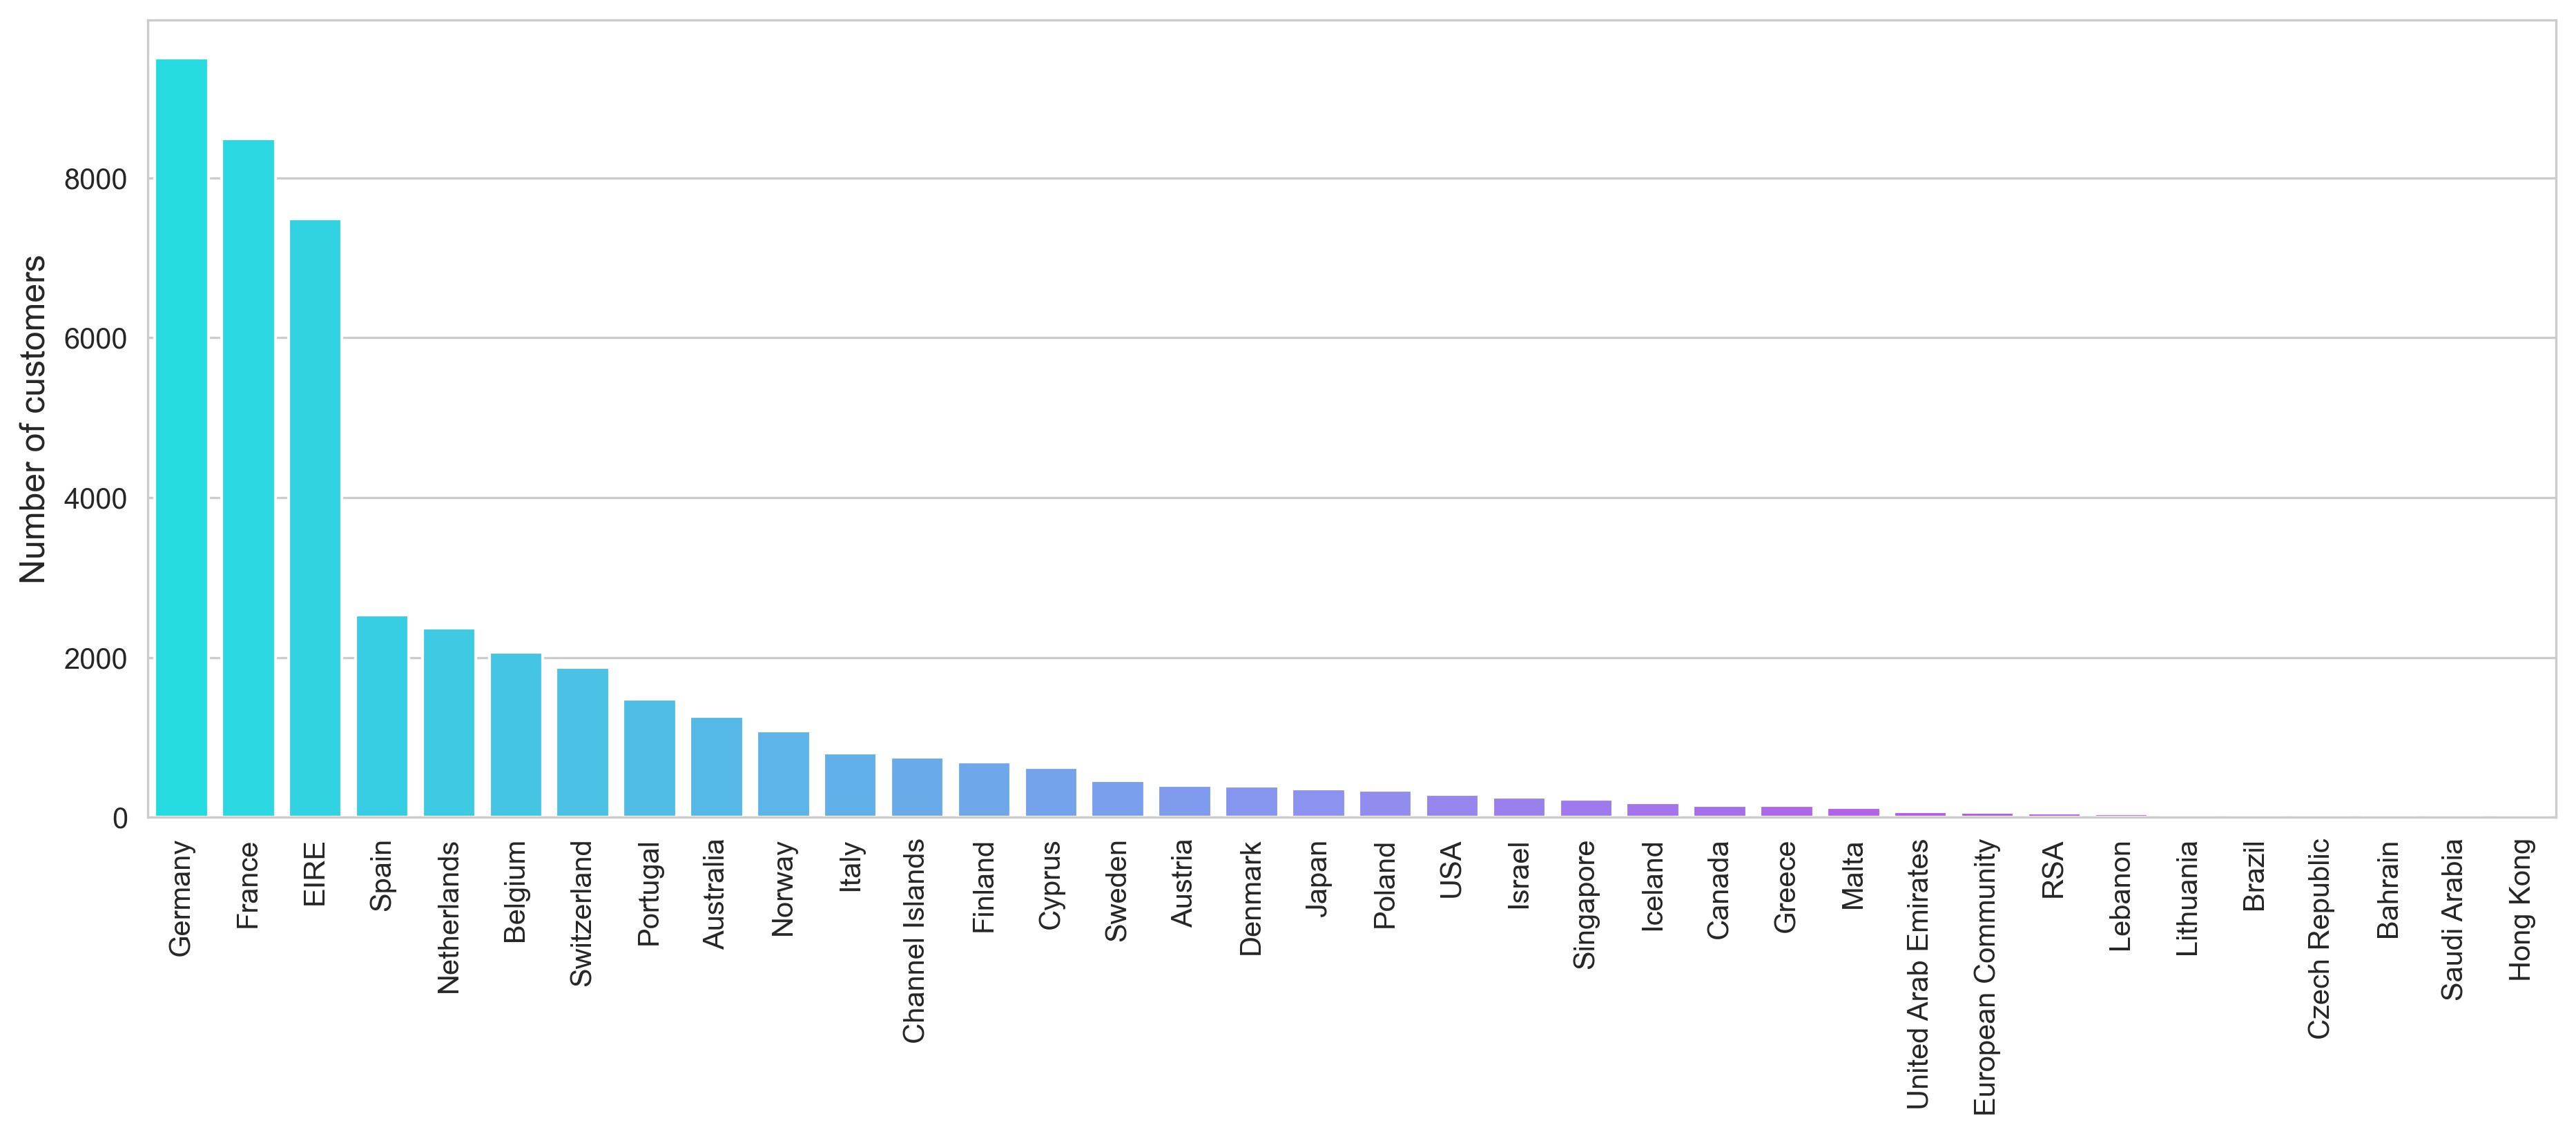

In [52]:
ax,fig = plt.subplots(figsize=(15,5),dpi=300)
ax = sns.barplot(x='Country',y='CustomerID',data=customers_per_country,hue_order='CustomerID',palette='cool')
plt.ylabel('Number of customers',fontsize=12)
plt.xlabel('',fontsize=12)
plt.xticks(rotation=90);

In [53]:
values_per_country = round(df_explore.groupby('Country')['Monetary'].sum().drop(['Unspecified','United Kingdom']).reset_index().sort_values(by='Monetary',ascending=False),0)

In [54]:
UK = df_explore[df_explore['Country'] == 'United Kingdom']['Monetary'].sum()
print(f'Total Revenue from the United Kingdom = {UK}$')

Total Revenue from the United Kingdom = 8187806.36$


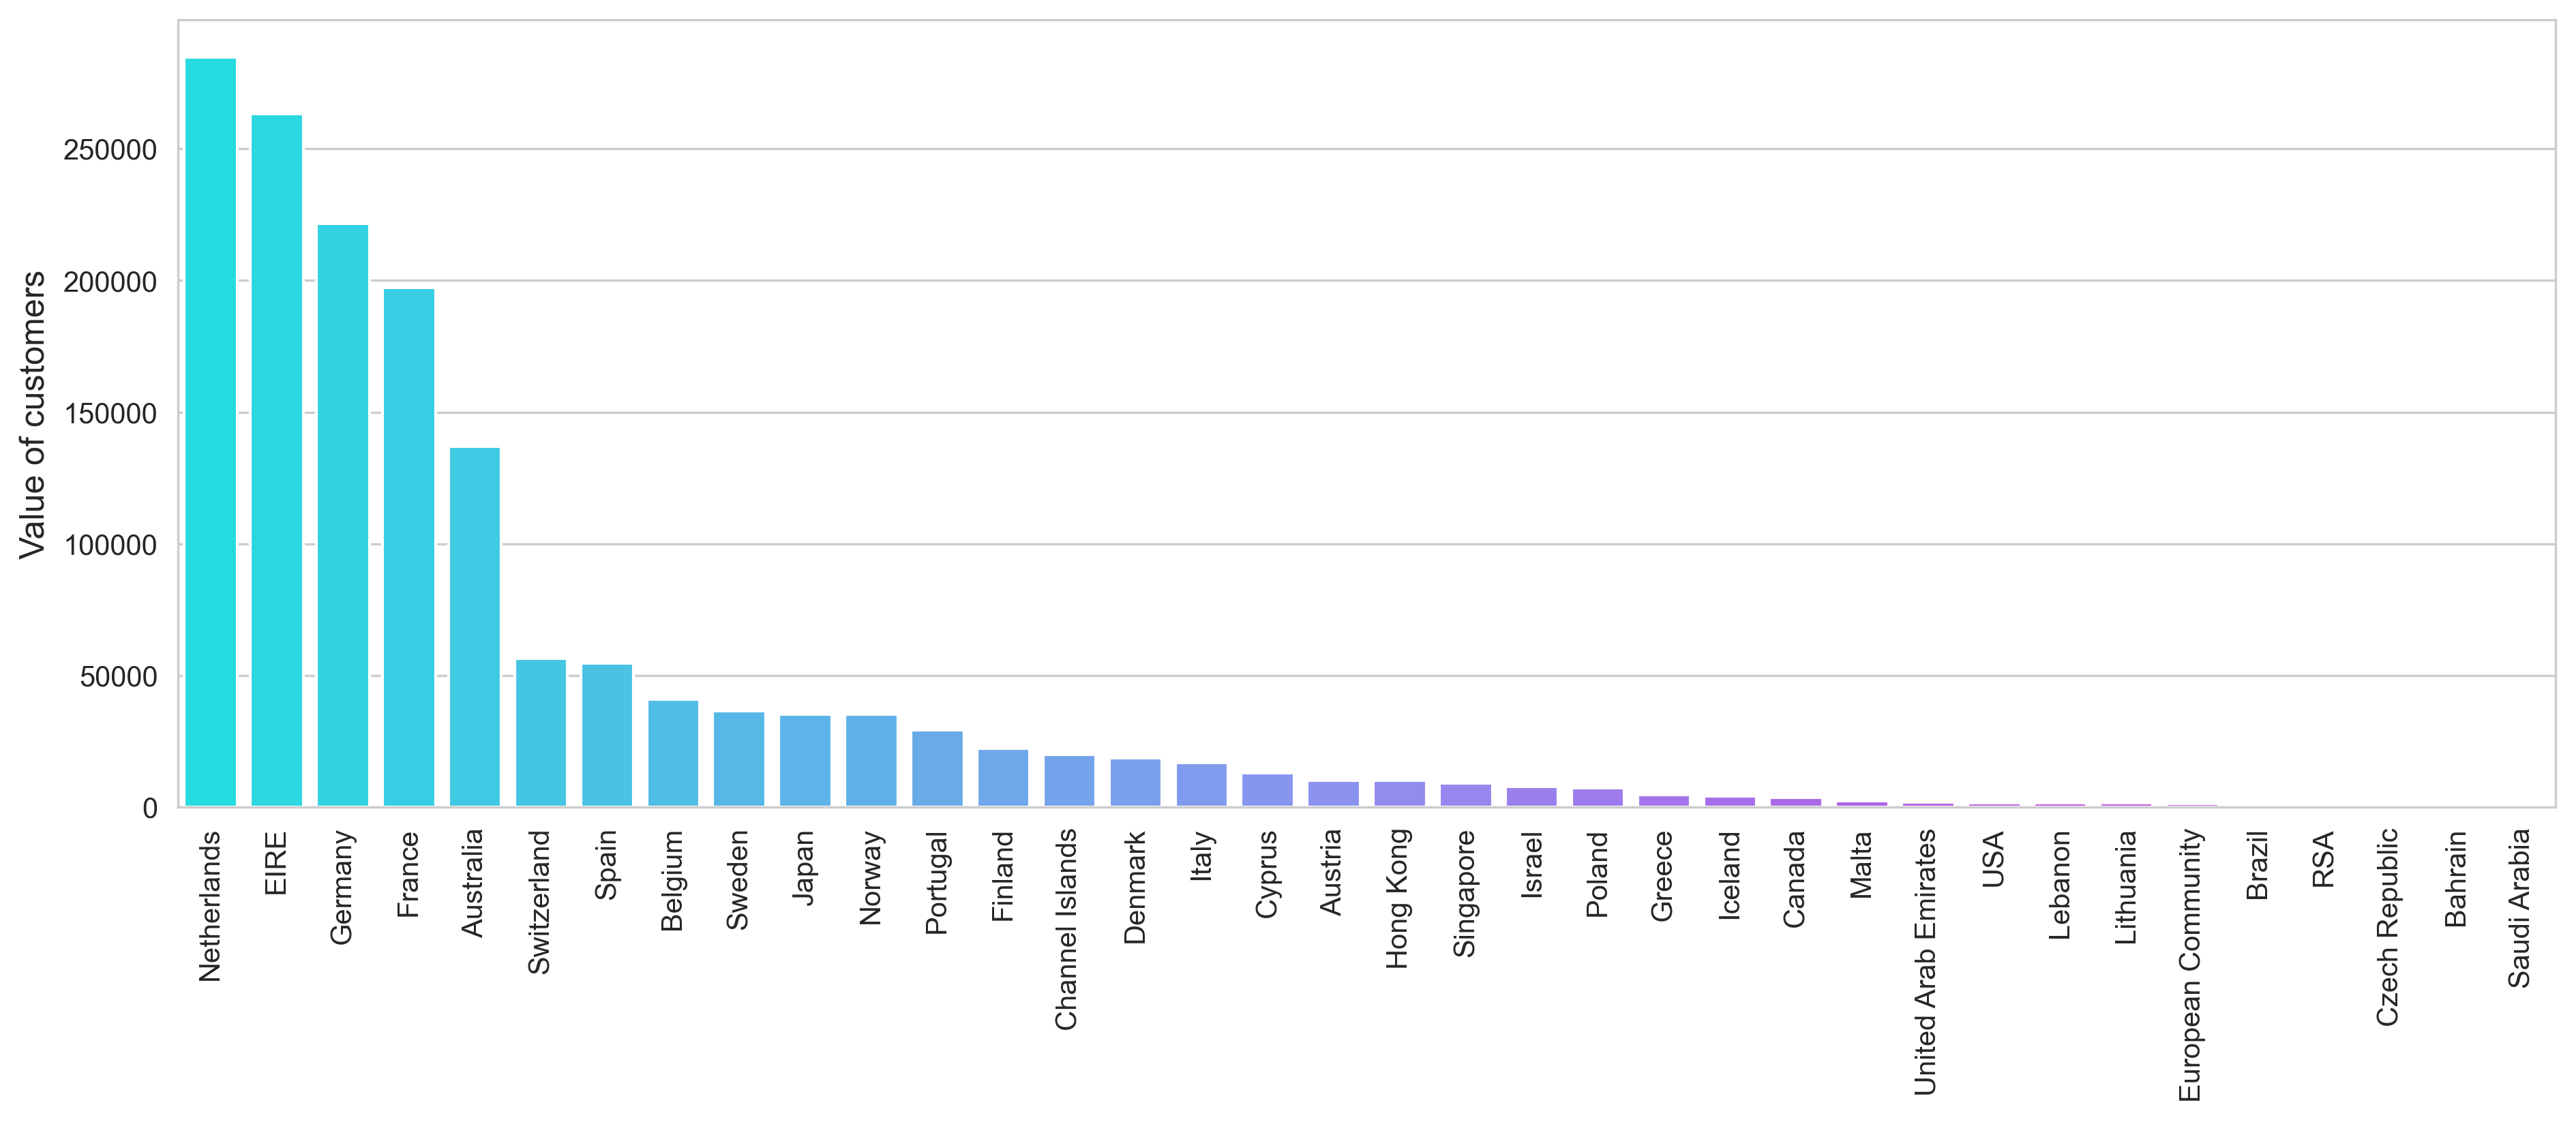

In [55]:
ax,fig = plt.subplots(figsize=(15,5),dpi=300)
ax = sns.barplot(x='Country',y='Monetary',data=values_per_country,hue_order='Monetary',palette='cool')
plt.ylabel('Value of customers',fontsize=12)
plt.xlabel('',fontsize=12)
plt.xticks(rotation=90);

In [56]:
best_item = pd.DataFrame(df_explore.groupby(['Country','Description'])['Quantity'].sum().drop('Unspecified',axis=0)).reset_index()
len(best_item['Country'].unique())

37

In [57]:
A = list(best_item['Country'].unique())
A.remove('EIRE')

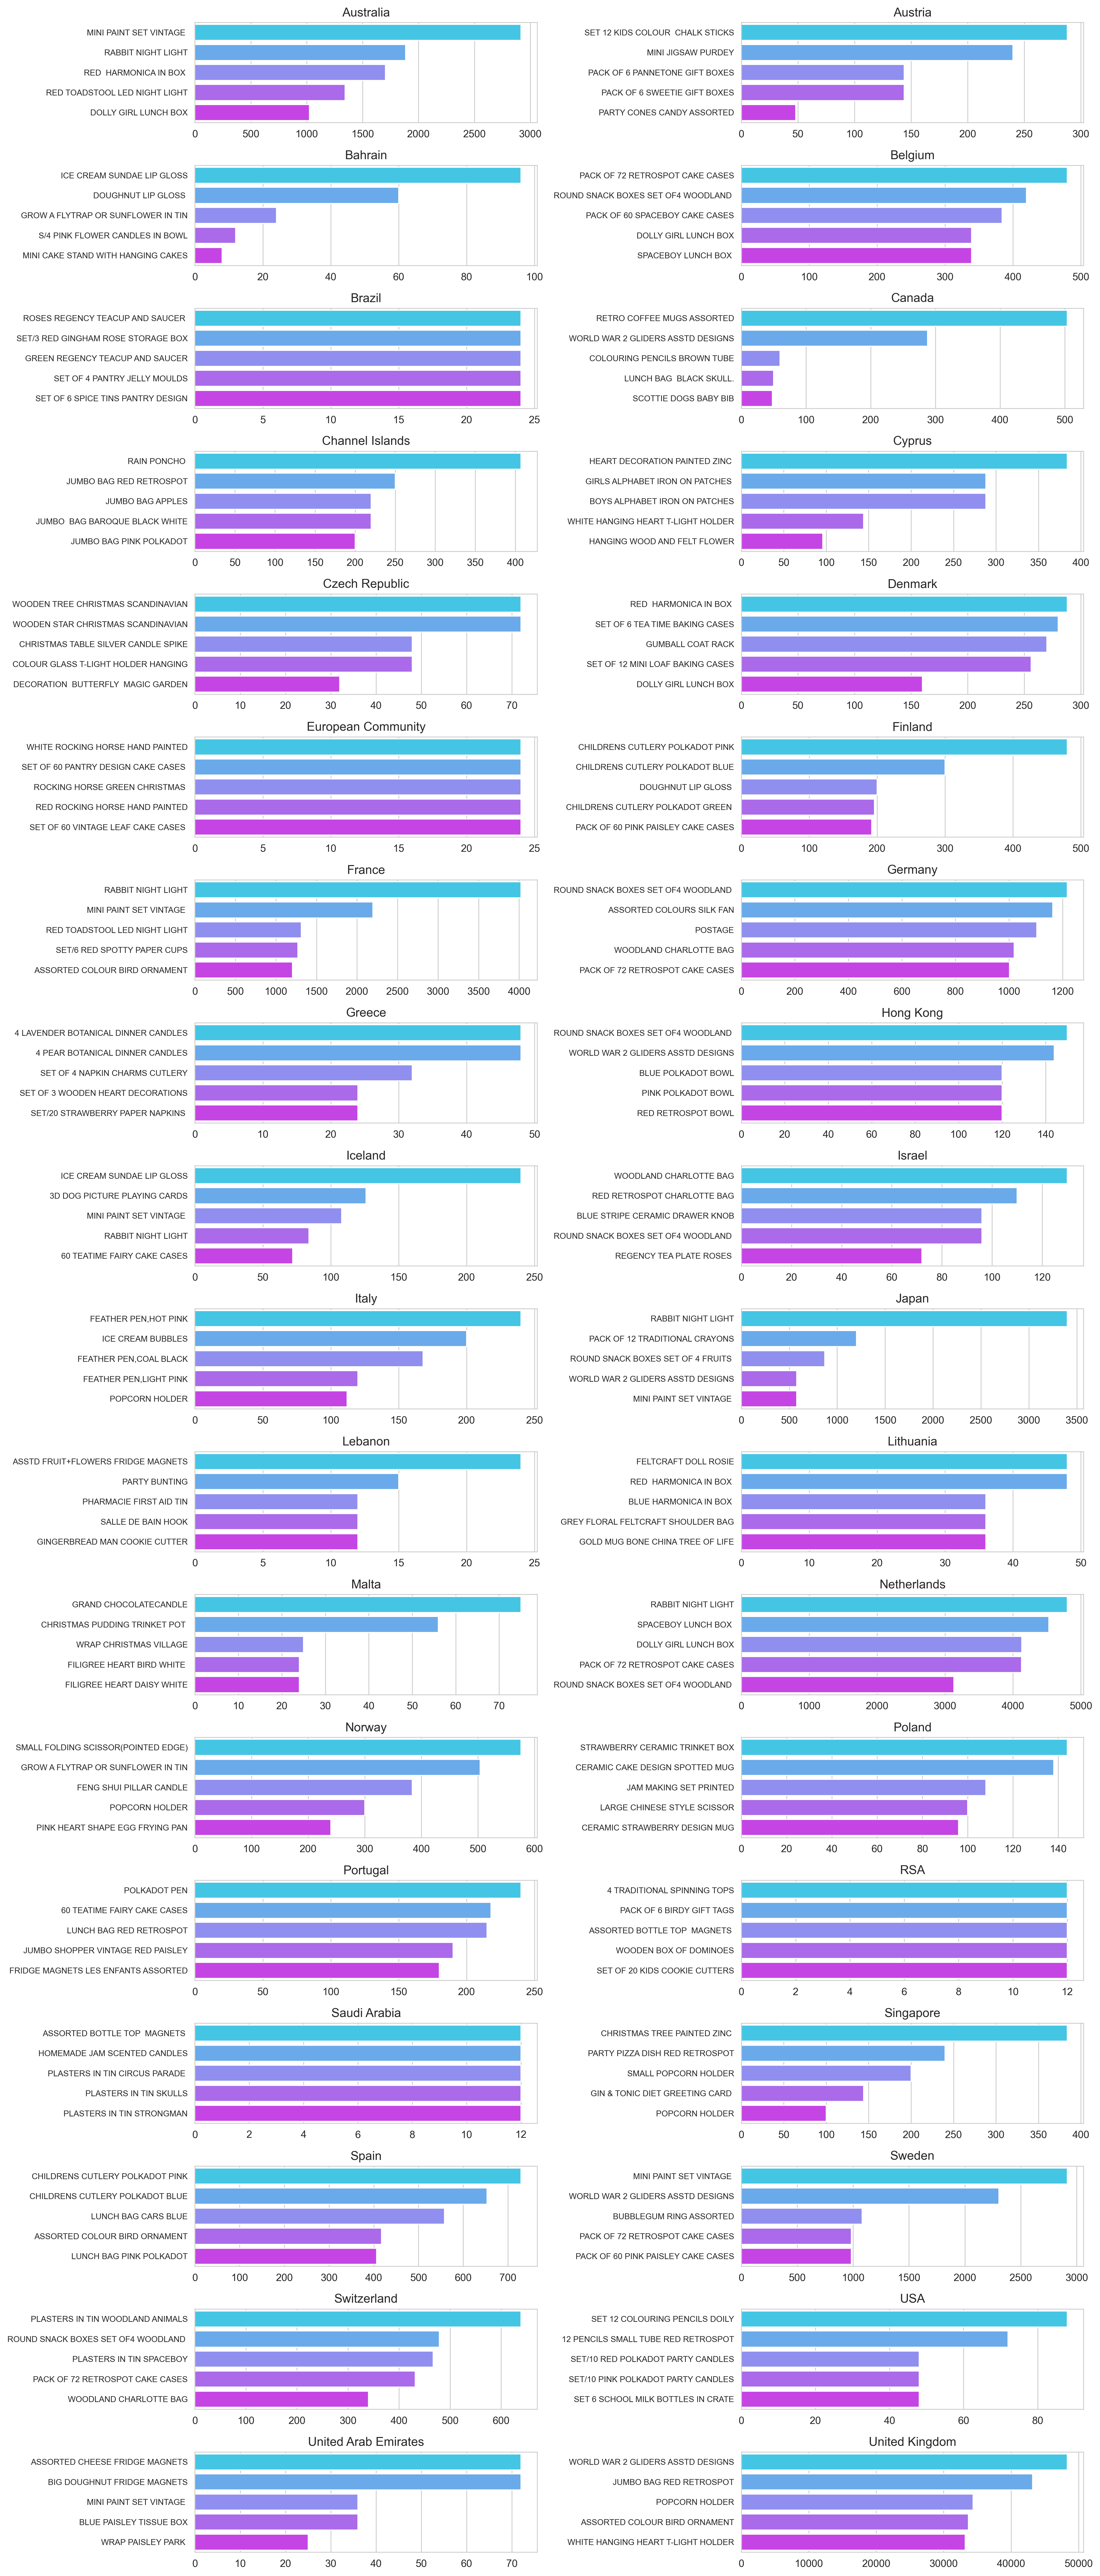

In [58]:
fig,ax = plt.subplots(18,2,figsize=(15,35),dpi=300,sharex=False,sharey=False)

i=0
for n_x in range(18):
    for n_y in range(2):
        c = best_item[best_item['Country'] == A[i]]
        c = c.sort_values(by='Quantity',ascending=False)
        c = c.iloc[0:5,:]

        if i < len(best_item['Country'].unique()):
            plot = sns.barplot(ax=ax[n_x][n_y],y=c['Description'],x=c['Quantity'],palette='cool',orient='h')
            ax[n_x][n_y].set_title(A[i],size=12)
            plot.set_yticklabels(c['Description'],size=8)
            plot.set_ylabel('')
            plot.set_xlabel('')
            
            i+=1
        else:
            break;
plt.tight_layout()


In [59]:
best_customers = pd.DataFrame(df_explore.groupby(['Country','CustomerID'])['Monetary'].sum().drop('Unspecified',axis=0)).reset_index()
len(best_customers['Country'].unique())

36

In [60]:
best_customers.head()

Country  CustomerID   Monetary
0  Australia     12386.0     401.90
1  Australia     12388.0    2780.66
2  Australia     12393.0    1582.60
3  Australia     12415.0  123725.45
4  Australia     12422.0     386.20

In [61]:
B = list(best_customers['Country'].unique())

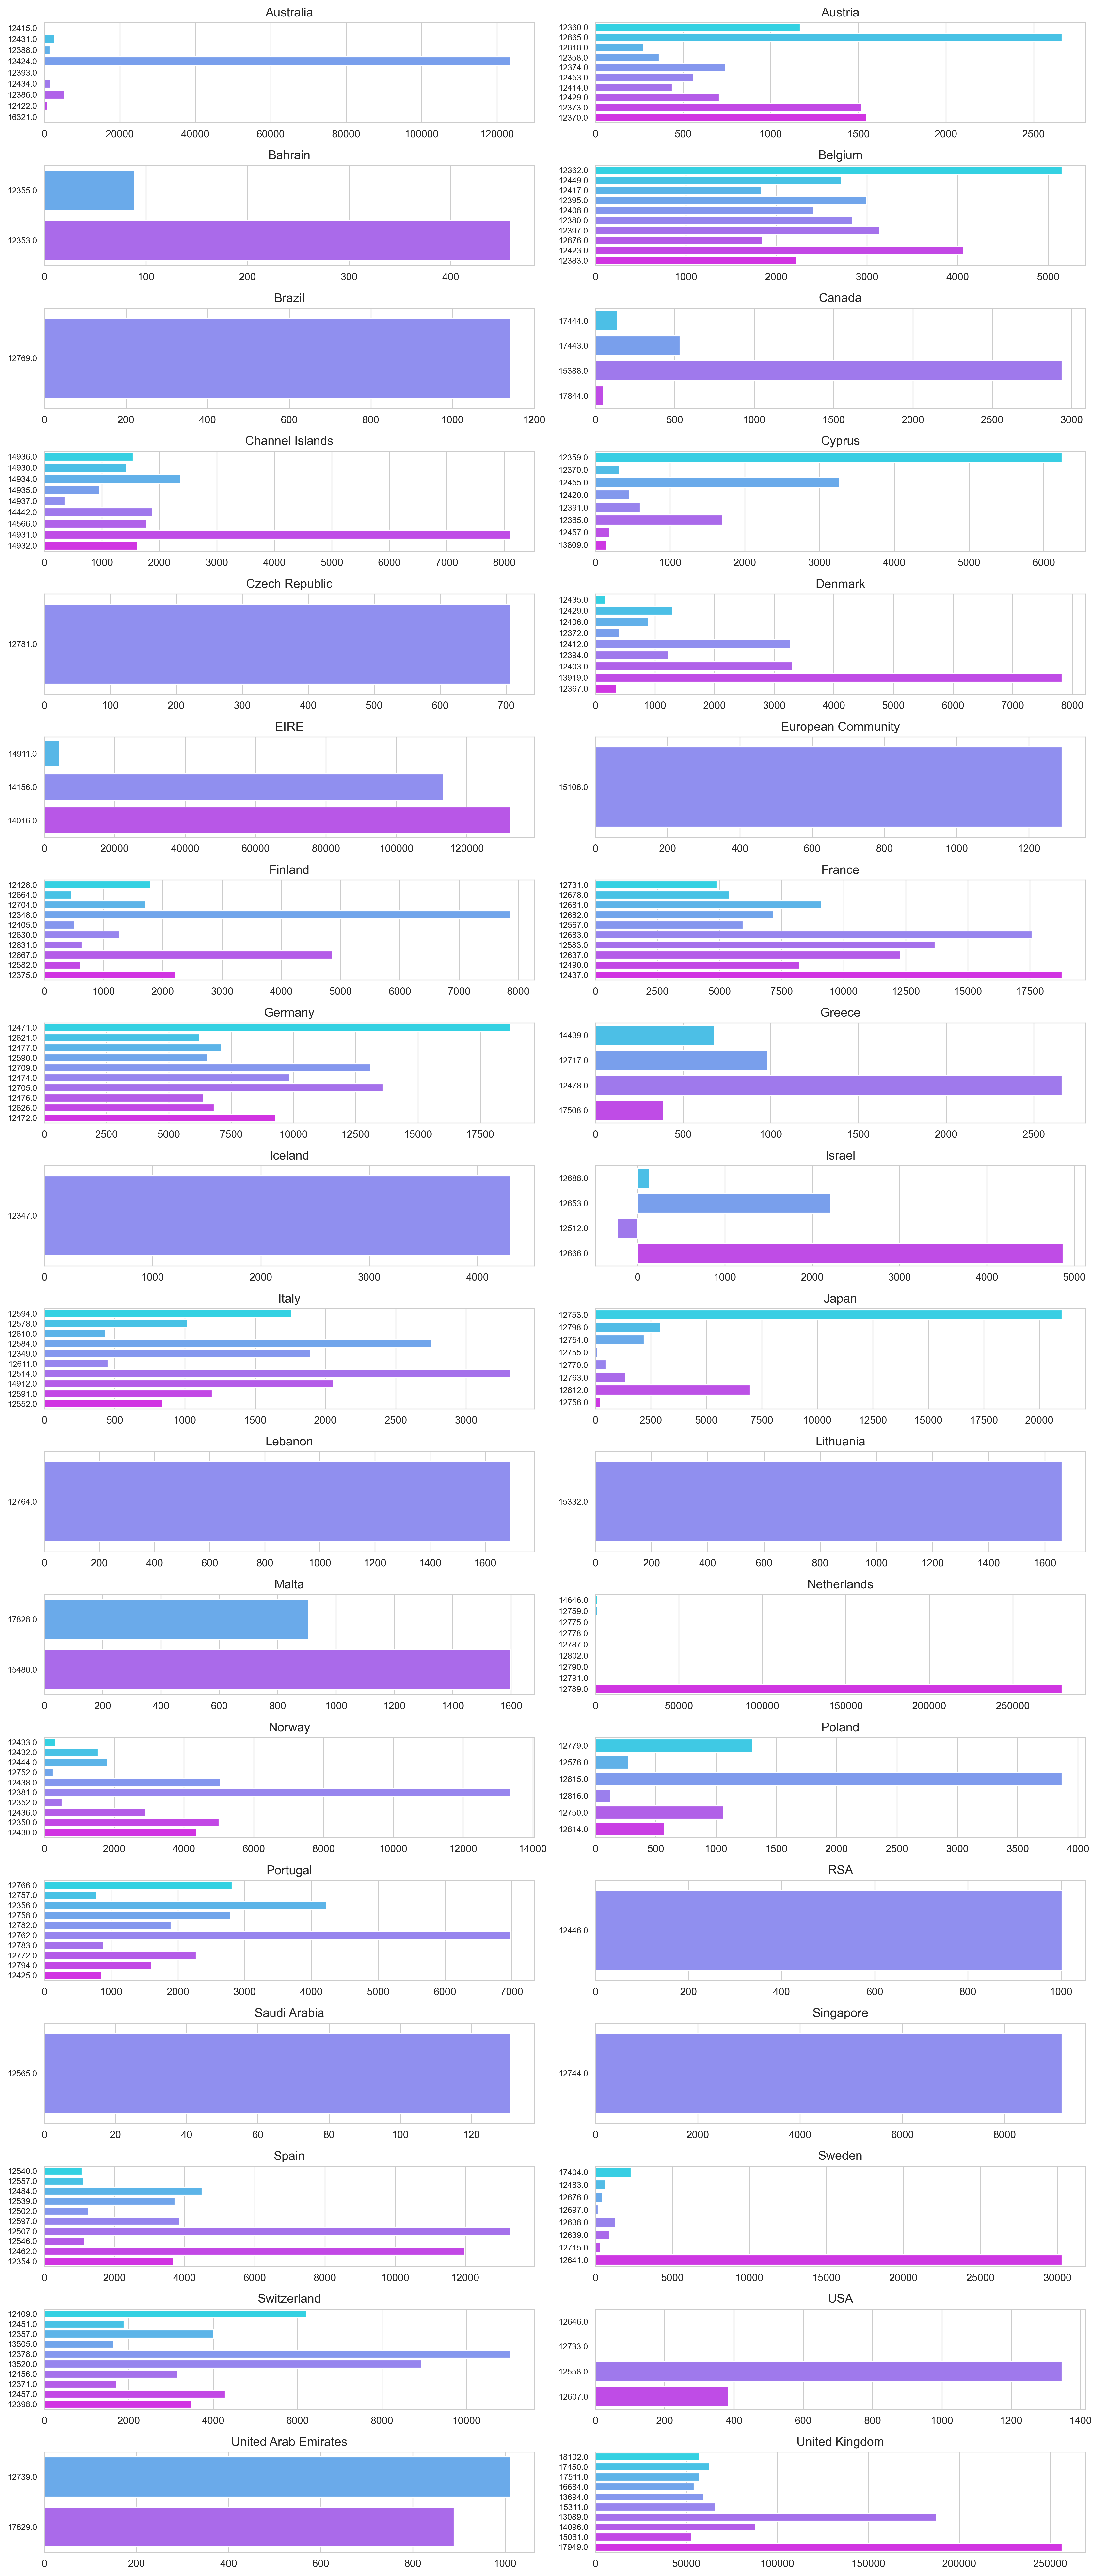

In [62]:
fig,ax = plt.subplots(18,2,figsize=(15,35),dpi=300,sharex=False,sharey=False)

i=0
for n_x in range(18):
    for n_y in range(2):
        c = best_customers[best_customers['Country'] == B[i]]
        c = c.sort_values(by='Monetary',ascending=False)
        c = c.iloc[0:10,:]

        if i < len(best_customers['Country'].unique()):
            plot = sns.barplot(ax=ax[n_x][n_y],y=c['CustomerID'],x=c['Monetary'],palette='cool',orient='h')
            ax[n_x][n_y].set_title(B[i],size=12)
            plot.set_yticklabels(c['CustomerID'],size=8)
            plot.set_ylabel('')
            plot.set_xlabel('')
            
            i+=1
        else:
            break;
plt.tight_layout()